# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

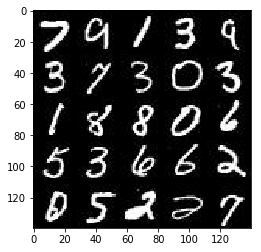

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

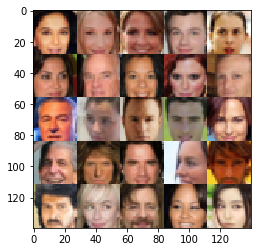

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, (None), name='learning_rate')
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        x1 = tf.maximum(x1, x1*alpha)
#         print(x1.get_shape())
        
        x2 = tf.layers.conv2d(x1, 112, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2*alpha)
#         print(x2.get_shape())
        
        x3 = tf.layers.conv2d(x2, 224, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3*alpha)
#         print(x3.get_shape())
        
        flat = tf.reshape(x3, (-1, 4*4*224))
        
        logits = tf.layers.dense(flat, 1)
#         print(logits.get_shape())
        
        out = tf.sigmoid(logits)
        
        return out, logits
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*224)
        
        x1 = tf.reshape(x1, (-1,7,7,224))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1, x1 * alpha)
#         print(x1.get_shape())
        # 4x4x224
        
        x2 = tf.layers.conv2d_transpose(x1, 112, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, x2 * alpha)
#         print(x2.get_shape())
        # 8x8x112
        
#         x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
#         x3 = tf.layers.batch_normalization(x3, training=is_train)
#         x3 = tf.maximum(x3, x3 * alpha)
#         print(x3.get_shape())
        # 16x16x56
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
#         print(logits.get_shape())
        # 28x28x3
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [34]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
#     sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    show_every = 100
    print_every = 10
    step = 0
    samples, losses = [], []
    
    img_height = data_shape[1]
    img_width = data_shape[2]
    img_depth = data_shape[3]
    
    input_real, input_z, lr = model_inputs(img_height, img_width, img_depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        show_generator_output(sess, 10, input_z, img_depth, data_image_mode)
        saver = tf.train.Saver()
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                # show image at start
                
                
                _ = sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                

                
                if step % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_every == 0:
                    show_generator_output(sess, 10, input_z, img_depth, data_image_mode)
                
        saver.save(sess, './checkpoints/generator.ckpt')       
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [17]:
!mkdir '\checkpoints'

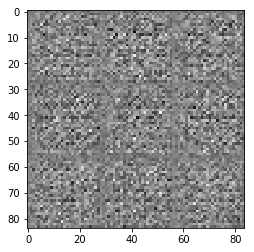

Epoch 1/2... Discriminator Loss: 3.1491... Generator Loss: 0.0757
Epoch 1/2... Discriminator Loss: 2.3547... Generator Loss: 0.2130
Epoch 1/2... Discriminator Loss: 1.9418... Generator Loss: 0.6985
Epoch 1/2... Discriminator Loss: 2.1140... Generator Loss: 0.5827
Epoch 1/2... Discriminator Loss: 1.5440... Generator Loss: 0.5206
Epoch 1/2... Discriminator Loss: 1.6893... Generator Loss: 0.4282
Epoch 1/2... Discriminator Loss: 1.8182... Generator Loss: 0.2504
Epoch 1/2... Discriminator Loss: 1.8365... Generator Loss: 0.2503
Epoch 1/2... Discriminator Loss: 1.8168... Generator Loss: 0.2273
Epoch 1/2... Discriminator Loss: 1.2858... Generator Loss: 0.6320


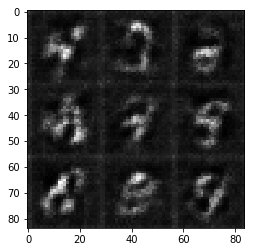

Epoch 1/2... Discriminator Loss: 1.3993... Generator Loss: 0.7946
Epoch 1/2... Discriminator Loss: 1.4142... Generator Loss: 0.5369
Epoch 1/2... Discriminator Loss: 1.4236... Generator Loss: 0.8606
Epoch 1/2... Discriminator Loss: 1.2811... Generator Loss: 0.9340
Epoch 1/2... Discriminator Loss: 1.2841... Generator Loss: 0.4239
Epoch 1/2... Discriminator Loss: 1.3102... Generator Loss: 0.5068
Epoch 1/2... Discriminator Loss: 1.6349... Generator Loss: 0.2658
Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 0.3412
Epoch 1/2... Discriminator Loss: 1.3719... Generator Loss: 1.3800
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.4383


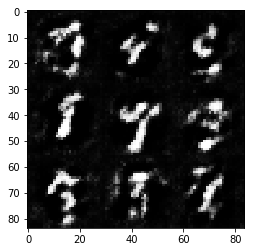

Epoch 1/2... Discriminator Loss: 1.1364... Generator Loss: 0.7031
Epoch 1/2... Discriminator Loss: 1.5800... Generator Loss: 0.2883
Epoch 1/2... Discriminator Loss: 1.0639... Generator Loss: 0.7749
Epoch 1/2... Discriminator Loss: 1.1589... Generator Loss: 0.6740
Epoch 1/2... Discriminator Loss: 1.2531... Generator Loss: 0.5248
Epoch 1/2... Discriminator Loss: 1.0021... Generator Loss: 0.7689
Epoch 1/2... Discriminator Loss: 1.1207... Generator Loss: 1.2854
Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 0.4345
Epoch 1/2... Discriminator Loss: 1.1328... Generator Loss: 0.6660
Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 0.4054


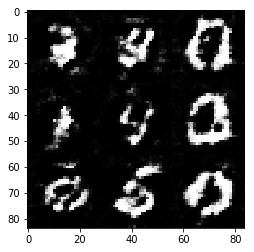

Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 0.5846
Epoch 1/2... Discriminator Loss: 1.1481... Generator Loss: 0.9231
Epoch 1/2... Discriminator Loss: 1.5054... Generator Loss: 0.3222
Epoch 1/2... Discriminator Loss: 1.2271... Generator Loss: 0.5618
Epoch 1/2... Discriminator Loss: 0.8511... Generator Loss: 1.0868
Epoch 1/2... Discriminator Loss: 1.6726... Generator Loss: 0.2982
Epoch 1/2... Discriminator Loss: 1.2301... Generator Loss: 0.9254
Epoch 1/2... Discriminator Loss: 1.1753... Generator Loss: 1.1148
Epoch 1/2... Discriminator Loss: 1.6796... Generator Loss: 0.2665
Epoch 1/2... Discriminator Loss: 1.2165... Generator Loss: 0.5068


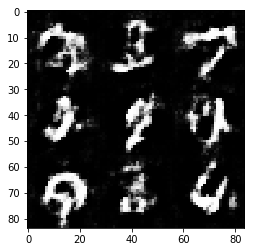

Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 0.4364
Epoch 1/2... Discriminator Loss: 1.8579... Generator Loss: 0.2054
Epoch 1/2... Discriminator Loss: 1.9174... Generator Loss: 0.2033
Epoch 1/2... Discriminator Loss: 1.5098... Generator Loss: 0.4333
Epoch 1/2... Discriminator Loss: 1.8578... Generator Loss: 0.2148
Epoch 1/2... Discriminator Loss: 1.4562... Generator Loss: 0.5143
Epoch 1/2... Discriminator Loss: 1.6851... Generator Loss: 0.2563
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.6800
Epoch 1/2... Discriminator Loss: 1.4023... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.3079... Generator Loss: 0.5895


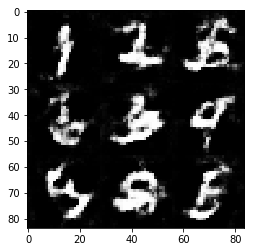

Epoch 1/2... Discriminator Loss: 1.1908... Generator Loss: 0.7848
Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 0.8286
Epoch 1/2... Discriminator Loss: 1.6250... Generator Loss: 0.2810
Epoch 1/2... Discriminator Loss: 1.3080... Generator Loss: 0.4543
Epoch 1/2... Discriminator Loss: 1.2464... Generator Loss: 0.7536
Epoch 1/2... Discriminator Loss: 1.1853... Generator Loss: 0.9094
Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 0.3826
Epoch 1/2... Discriminator Loss: 1.3838... Generator Loss: 1.3296
Epoch 1/2... Discriminator Loss: 1.4172... Generator Loss: 0.4583
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.5336


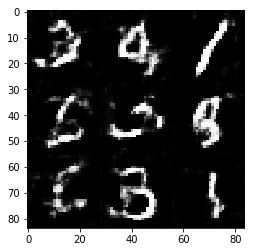

Epoch 1/2... Discriminator Loss: 1.1598... Generator Loss: 0.9235
Epoch 1/2... Discriminator Loss: 1.5721... Generator Loss: 0.3076
Epoch 1/2... Discriminator Loss: 1.4815... Generator Loss: 0.3380
Epoch 1/2... Discriminator Loss: 1.0860... Generator Loss: 1.0128
Epoch 1/2... Discriminator Loss: 1.4525... Generator Loss: 0.9310
Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.4356
Epoch 1/2... Discriminator Loss: 1.6887... Generator Loss: 0.2609
Epoch 1/2... Discriminator Loss: 1.3117... Generator Loss: 1.0751
Epoch 1/2... Discriminator Loss: 1.3311... Generator Loss: 0.6732
Epoch 1/2... Discriminator Loss: 1.7437... Generator Loss: 0.2416


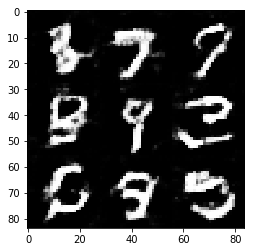

Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.8345
Epoch 1/2... Discriminator Loss: 1.6866... Generator Loss: 0.2675
Epoch 1/2... Discriminator Loss: 1.0428... Generator Loss: 0.9815
Epoch 1/2... Discriminator Loss: 1.2430... Generator Loss: 1.0098
Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 0.4404
Epoch 1/2... Discriminator Loss: 1.4213... Generator Loss: 0.4233
Epoch 1/2... Discriminator Loss: 1.3027... Generator Loss: 0.4926
Epoch 1/2... Discriminator Loss: 1.6150... Generator Loss: 0.3133
Epoch 1/2... Discriminator Loss: 1.3022... Generator Loss: 0.5475
Epoch 1/2... Discriminator Loss: 1.5428... Generator Loss: 0.3543


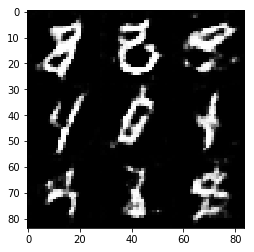

Epoch 1/2... Discriminator Loss: 1.7579... Generator Loss: 1.3811
Epoch 1/2... Discriminator Loss: 1.2077... Generator Loss: 0.5571
Epoch 1/2... Discriminator Loss: 1.2893... Generator Loss: 0.5067
Epoch 1/2... Discriminator Loss: 1.2009... Generator Loss: 0.9983
Epoch 1/2... Discriminator Loss: 1.0654... Generator Loss: 0.8178
Epoch 1/2... Discriminator Loss: 1.4332... Generator Loss: 0.4593
Epoch 1/2... Discriminator Loss: 0.9832... Generator Loss: 0.9741
Epoch 1/2... Discriminator Loss: 1.4964... Generator Loss: 0.3087
Epoch 1/2... Discriminator Loss: 1.1790... Generator Loss: 0.5460
Epoch 1/2... Discriminator Loss: 1.7849... Generator Loss: 0.2419


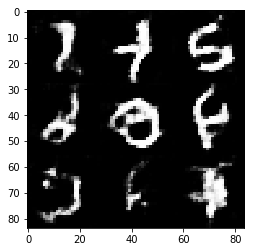

Epoch 1/2... Discriminator Loss: 1.9749... Generator Loss: 0.1935
Epoch 1/2... Discriminator Loss: 1.1508... Generator Loss: 0.5873
Epoch 1/2... Discriminator Loss: 1.6166... Generator Loss: 0.2697
Epoch 1/2... Discriminator Loss: 1.1301... Generator Loss: 0.7769
Epoch 1/2... Discriminator Loss: 1.5417... Generator Loss: 0.3154
Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 0.4710
Epoch 1/2... Discriminator Loss: 1.6395... Generator Loss: 0.2566
Epoch 1/2... Discriminator Loss: 1.3770... Generator Loss: 0.4417
Epoch 1/2... Discriminator Loss: 1.8681... Generator Loss: 0.2059
Epoch 1/2... Discriminator Loss: 1.2207... Generator Loss: 0.5244


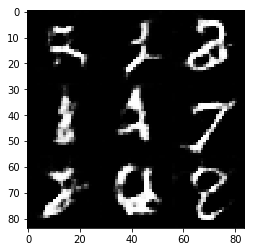

Epoch 1/2... Discriminator Loss: 1.0271... Generator Loss: 0.6531
Epoch 1/2... Discriminator Loss: 1.5491... Generator Loss: 0.3384
Epoch 1/2... Discriminator Loss: 0.8839... Generator Loss: 1.0058
Epoch 1/2... Discriminator Loss: 1.1049... Generator Loss: 0.7397
Epoch 1/2... Discriminator Loss: 1.6220... Generator Loss: 0.3050
Epoch 1/2... Discriminator Loss: 1.5110... Generator Loss: 1.7451
Epoch 1/2... Discriminator Loss: 1.5556... Generator Loss: 0.3065
Epoch 1/2... Discriminator Loss: 1.0187... Generator Loss: 0.6718
Epoch 1/2... Discriminator Loss: 1.8340... Generator Loss: 0.2193
Epoch 1/2... Discriminator Loss: 1.2376... Generator Loss: 0.5079


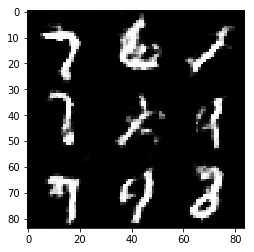

Epoch 1/2... Discriminator Loss: 1.2615... Generator Loss: 0.4720
Epoch 1/2... Discriminator Loss: 1.5184... Generator Loss: 0.3081
Epoch 1/2... Discriminator Loss: 2.1281... Generator Loss: 0.1604
Epoch 1/2... Discriminator Loss: 1.6945... Generator Loss: 0.2446
Epoch 1/2... Discriminator Loss: 1.2859... Generator Loss: 0.4198
Epoch 1/2... Discriminator Loss: 2.5711... Generator Loss: 0.1002
Epoch 1/2... Discriminator Loss: 1.1506... Generator Loss: 0.6191
Epoch 1/2... Discriminator Loss: 1.3665... Generator Loss: 1.2265
Epoch 1/2... Discriminator Loss: 1.4656... Generator Loss: 1.9164
Epoch 1/2... Discriminator Loss: 1.1429... Generator Loss: 0.5627


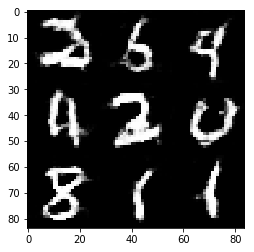

Epoch 1/2... Discriminator Loss: 1.5343... Generator Loss: 0.3198
Epoch 1/2... Discriminator Loss: 0.9134... Generator Loss: 0.8509
Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 0.6919
Epoch 1/2... Discriminator Loss: 1.1193... Generator Loss: 0.5166
Epoch 1/2... Discriminator Loss: 1.4485... Generator Loss: 0.3269
Epoch 1/2... Discriminator Loss: 2.5589... Generator Loss: 0.1114
Epoch 1/2... Discriminator Loss: 1.4000... Generator Loss: 0.4048
Epoch 1/2... Discriminator Loss: 1.0626... Generator Loss: 0.5952
Epoch 1/2... Discriminator Loss: 1.4358... Generator Loss: 0.3537
Epoch 1/2... Discriminator Loss: 1.2452... Generator Loss: 0.4530


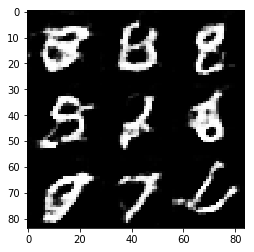

Epoch 1/2... Discriminator Loss: 1.9366... Generator Loss: 0.2257
Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 0.7251
Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 0.4870
Epoch 1/2... Discriminator Loss: 1.6468... Generator Loss: 0.2960
Epoch 1/2... Discriminator Loss: 1.5339... Generator Loss: 0.3538
Epoch 1/2... Discriminator Loss: 1.4963... Generator Loss: 0.3172
Epoch 1/2... Discriminator Loss: 3.3880... Generator Loss: 0.0555
Epoch 1/2... Discriminator Loss: 1.1622... Generator Loss: 0.6042
Epoch 1/2... Discriminator Loss: 1.4916... Generator Loss: 0.3137
Epoch 1/2... Discriminator Loss: 1.2199... Generator Loss: 0.6534


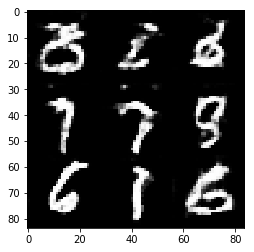

Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.4270
Epoch 1/2... Discriminator Loss: 1.3707... Generator Loss: 0.3606
Epoch 1/2... Discriminator Loss: 1.4154... Generator Loss: 0.3829
Epoch 1/2... Discriminator Loss: 1.3173... Generator Loss: 0.4783
Epoch 1/2... Discriminator Loss: 1.5706... Generator Loss: 0.3330
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 0.4252
Epoch 1/2... Discriminator Loss: 1.8313... Generator Loss: 0.2334
Epoch 1/2... Discriminator Loss: 1.4540... Generator Loss: 0.3489
Epoch 1/2... Discriminator Loss: 1.9174... Generator Loss: 0.2103
Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 0.7737


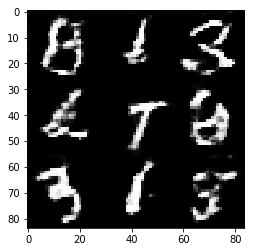

Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 0.3856
Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 0.5154
Epoch 1/2... Discriminator Loss: 1.6299... Generator Loss: 0.2891
Epoch 1/2... Discriminator Loss: 1.3062... Generator Loss: 0.4474
Epoch 1/2... Discriminator Loss: 1.2378... Generator Loss: 0.4814
Epoch 1/2... Discriminator Loss: 0.8486... Generator Loss: 0.7947
Epoch 1/2... Discriminator Loss: 1.5154... Generator Loss: 0.3301
Epoch 1/2... Discriminator Loss: 1.6807... Generator Loss: 0.2915
Epoch 1/2... Discriminator Loss: 3.9969... Generator Loss: 0.0480
Epoch 1/2... Discriminator Loss: 1.2554... Generator Loss: 0.4929


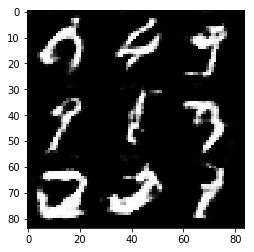

Epoch 1/2... Discriminator Loss: 1.3735... Generator Loss: 0.4365
Epoch 1/2... Discriminator Loss: 1.4036... Generator Loss: 0.4085
Epoch 1/2... Discriminator Loss: 1.0056... Generator Loss: 0.5779
Epoch 1/2... Discriminator Loss: 1.3274... Generator Loss: 0.4392
Epoch 1/2... Discriminator Loss: 1.7184... Generator Loss: 0.2513
Epoch 1/2... Discriminator Loss: 1.4478... Generator Loss: 0.3594
Epoch 1/2... Discriminator Loss: 1.2712... Generator Loss: 0.5164
Epoch 1/2... Discriminator Loss: 1.6059... Generator Loss: 0.3063
Epoch 1/2... Discriminator Loss: 1.7761... Generator Loss: 0.2573
Epoch 1/2... Discriminator Loss: 1.2212... Generator Loss: 0.5268


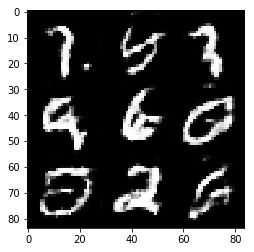

Epoch 1/2... Discriminator Loss: 1.6972... Generator Loss: 0.3098
Epoch 1/2... Discriminator Loss: 1.1445... Generator Loss: 0.6249
Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 0.3805
Epoch 1/2... Discriminator Loss: 1.3654... Generator Loss: 2.3505
Epoch 1/2... Discriminator Loss: 0.9757... Generator Loss: 0.8191
Epoch 1/2... Discriminator Loss: 1.7326... Generator Loss: 0.2406
Epoch 1/2... Discriminator Loss: 1.0737... Generator Loss: 0.6124
Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 0.4765
Epoch 1/2... Discriminator Loss: 1.5319... Generator Loss: 0.3524
Epoch 1/2... Discriminator Loss: 1.4373... Generator Loss: 0.3967


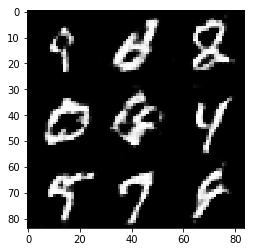

Epoch 1/2... Discriminator Loss: 3.3067... Generator Loss: 0.0578
Epoch 1/2... Discriminator Loss: 1.8584... Generator Loss: 0.2144
Epoch 1/2... Discriminator Loss: 1.8549... Generator Loss: 0.2067
Epoch 1/2... Discriminator Loss: 1.5331... Generator Loss: 0.3246
Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 0.5756
Epoch 1/2... Discriminator Loss: 1.9442... Generator Loss: 0.1963
Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 0.8810
Epoch 2/2... Discriminator Loss: 1.0663... Generator Loss: 0.6116
Epoch 2/2... Discriminator Loss: 0.8535... Generator Loss: 0.8670
Epoch 2/2... Discriminator Loss: 1.5417... Generator Loss: 0.3280


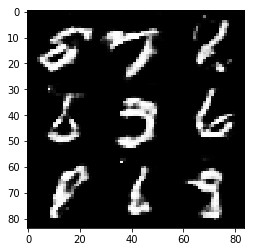

Epoch 2/2... Discriminator Loss: 2.9481... Generator Loss: 0.0872
Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 1.8645
Epoch 2/2... Discriminator Loss: 0.9730... Generator Loss: 0.6438
Epoch 2/2... Discriminator Loss: 1.2266... Generator Loss: 0.4722
Epoch 2/2... Discriminator Loss: 1.3623... Generator Loss: 0.3871
Epoch 2/2... Discriminator Loss: 1.0136... Generator Loss: 0.6047
Epoch 2/2... Discriminator Loss: 2.6527... Generator Loss: 3.4935
Epoch 2/2... Discriminator Loss: 1.2659... Generator Loss: 0.4727
Epoch 2/2... Discriminator Loss: 1.0292... Generator Loss: 0.5907
Epoch 2/2... Discriminator Loss: 1.7829... Generator Loss: 0.2709


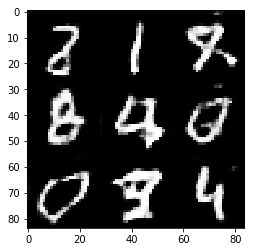

Epoch 2/2... Discriminator Loss: 1.4787... Generator Loss: 0.3464
Epoch 2/2... Discriminator Loss: 1.2853... Generator Loss: 0.3910
Epoch 2/2... Discriminator Loss: 1.3480... Generator Loss: 0.3664
Epoch 2/2... Discriminator Loss: 1.0857... Generator Loss: 0.5534
Epoch 2/2... Discriminator Loss: 2.3651... Generator Loss: 0.1253
Epoch 2/2... Discriminator Loss: 1.8643... Generator Loss: 0.2225
Epoch 2/2... Discriminator Loss: 2.9472... Generator Loss: 0.0922
Epoch 2/2... Discriminator Loss: 1.9201... Generator Loss: 0.2142
Epoch 2/2... Discriminator Loss: 1.9268... Generator Loss: 0.2350
Epoch 2/2... Discriminator Loss: 2.7058... Generator Loss: 3.3483


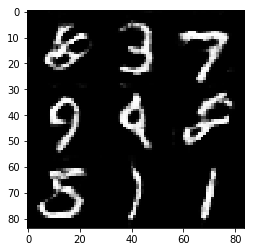

Epoch 2/2... Discriminator Loss: 0.8277... Generator Loss: 2.2530
Epoch 2/2... Discriminator Loss: 1.0349... Generator Loss: 0.6437
Epoch 2/2... Discriminator Loss: 0.8439... Generator Loss: 1.3003
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 0.6953
Epoch 2/2... Discriminator Loss: 1.9863... Generator Loss: 0.2131
Epoch 2/2... Discriminator Loss: 1.2463... Generator Loss: 0.4095
Epoch 2/2... Discriminator Loss: 1.1322... Generator Loss: 0.5354
Epoch 2/2... Discriminator Loss: 1.0526... Generator Loss: 0.6097
Epoch 2/2... Discriminator Loss: 1.2092... Generator Loss: 0.4926
Epoch 2/2... Discriminator Loss: 1.9166... Generator Loss: 0.2230


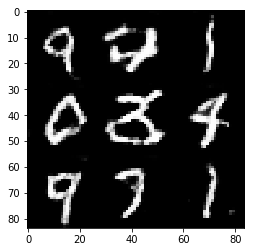

Epoch 2/2... Discriminator Loss: 1.5901... Generator Loss: 0.2968
Epoch 2/2... Discriminator Loss: 1.6119... Generator Loss: 0.3274
Epoch 2/2... Discriminator Loss: 2.2525... Generator Loss: 3.6686
Epoch 2/2... Discriminator Loss: 1.4892... Generator Loss: 0.3425
Epoch 2/2... Discriminator Loss: 1.7552... Generator Loss: 0.2545
Epoch 2/2... Discriminator Loss: 1.3138... Generator Loss: 0.4635
Epoch 2/2... Discriminator Loss: 1.0634... Generator Loss: 0.5934
Epoch 2/2... Discriminator Loss: 1.3105... Generator Loss: 0.4752
Epoch 2/2... Discriminator Loss: 1.7214... Generator Loss: 0.2741
Epoch 2/2... Discriminator Loss: 1.3161... Generator Loss: 0.4129


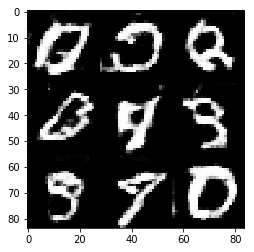

Epoch 2/2... Discriminator Loss: 2.1927... Generator Loss: 0.1540
Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.4038
Epoch 2/2... Discriminator Loss: 1.3995... Generator Loss: 0.3869
Epoch 2/2... Discriminator Loss: 0.9838... Generator Loss: 0.6796
Epoch 2/2... Discriminator Loss: 1.1306... Generator Loss: 0.5808
Epoch 2/2... Discriminator Loss: 2.3491... Generator Loss: 0.1408
Epoch 2/2... Discriminator Loss: 1.5969... Generator Loss: 0.3486
Epoch 2/2... Discriminator Loss: 1.5304... Generator Loss: 0.3630
Epoch 2/2... Discriminator Loss: 1.3227... Generator Loss: 0.4046
Epoch 2/2... Discriminator Loss: 1.5628... Generator Loss: 0.3243


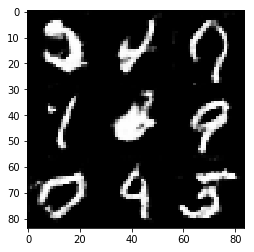

Epoch 2/2... Discriminator Loss: 1.5016... Generator Loss: 0.3098
Epoch 2/2... Discriminator Loss: 1.4292... Generator Loss: 0.3460
Epoch 2/2... Discriminator Loss: 2.6716... Generator Loss: 0.1056
Epoch 2/2... Discriminator Loss: 2.0218... Generator Loss: 0.1922
Epoch 2/2... Discriminator Loss: 1.6145... Generator Loss: 0.3188
Epoch 2/2... Discriminator Loss: 1.4148... Generator Loss: 0.7542
Epoch 2/2... Discriminator Loss: 0.8208... Generator Loss: 1.5702
Epoch 2/2... Discriminator Loss: 0.7407... Generator Loss: 1.3831
Epoch 2/2... Discriminator Loss: 1.6927... Generator Loss: 0.2838
Epoch 2/2... Discriminator Loss: 1.1256... Generator Loss: 0.5817


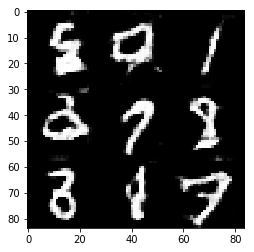

Epoch 2/2... Discriminator Loss: 1.5580... Generator Loss: 0.3694
Epoch 2/2... Discriminator Loss: 1.0706... Generator Loss: 0.5515
Epoch 2/2... Discriminator Loss: 1.5511... Generator Loss: 0.3232
Epoch 2/2... Discriminator Loss: 1.3611... Generator Loss: 0.3826
Epoch 2/2... Discriminator Loss: 1.7978... Generator Loss: 0.2471
Epoch 2/2... Discriminator Loss: 1.3038... Generator Loss: 0.4870
Epoch 2/2... Discriminator Loss: 0.9402... Generator Loss: 0.6530
Epoch 2/2... Discriminator Loss: 1.9691... Generator Loss: 0.2318
Epoch 2/2... Discriminator Loss: 2.3259... Generator Loss: 3.7184
Epoch 2/2... Discriminator Loss: 1.4896... Generator Loss: 0.3915


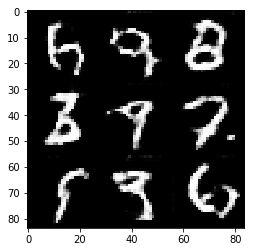

Epoch 2/2... Discriminator Loss: 1.0643... Generator Loss: 0.5424
Epoch 2/2... Discriminator Loss: 1.0452... Generator Loss: 0.6102
Epoch 2/2... Discriminator Loss: 1.6842... Generator Loss: 0.2759
Epoch 2/2... Discriminator Loss: 1.0924... Generator Loss: 0.5179
Epoch 2/2... Discriminator Loss: 1.4712... Generator Loss: 0.3564
Epoch 2/2... Discriminator Loss: 1.5643... Generator Loss: 4.1639
Epoch 2/2... Discriminator Loss: 2.0405... Generator Loss: 0.2054
Epoch 2/2... Discriminator Loss: 1.1695... Generator Loss: 0.5775
Epoch 2/2... Discriminator Loss: 1.6913... Generator Loss: 0.2620
Epoch 2/2... Discriminator Loss: 1.3058... Generator Loss: 0.4551


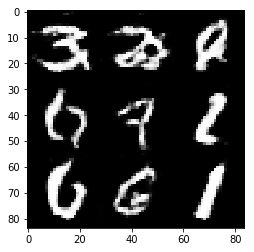

Epoch 2/2... Discriminator Loss: 1.6687... Generator Loss: 0.3206
Epoch 2/2... Discriminator Loss: 1.8365... Generator Loss: 0.2440
Epoch 2/2... Discriminator Loss: 1.9049... Generator Loss: 0.2844
Epoch 2/2... Discriminator Loss: 1.1571... Generator Loss: 0.5052
Epoch 2/2... Discriminator Loss: 1.7777... Generator Loss: 0.2796
Epoch 2/2... Discriminator Loss: 1.2327... Generator Loss: 0.4640
Epoch 2/2... Discriminator Loss: 1.6929... Generator Loss: 0.2636
Epoch 2/2... Discriminator Loss: 1.6263... Generator Loss: 0.3475
Epoch 2/2... Discriminator Loss: 1.3227... Generator Loss: 0.4525
Epoch 2/2... Discriminator Loss: 1.3939... Generator Loss: 0.4336


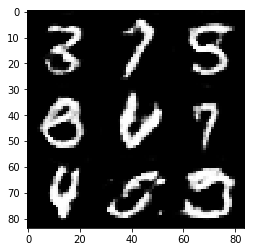

Epoch 2/2... Discriminator Loss: 1.6694... Generator Loss: 0.2819
Epoch 2/2... Discriminator Loss: 1.4391... Generator Loss: 0.4024
Epoch 2/2... Discriminator Loss: 1.4405... Generator Loss: 0.4269
Epoch 2/2... Discriminator Loss: 1.6490... Generator Loss: 0.2960
Epoch 2/2... Discriminator Loss: 2.0107... Generator Loss: 0.2030
Epoch 2/2... Discriminator Loss: 2.1044... Generator Loss: 0.1752
Epoch 2/2... Discriminator Loss: 1.8486... Generator Loss: 0.2366
Epoch 2/2... Discriminator Loss: 1.1391... Generator Loss: 0.5549
Epoch 2/2... Discriminator Loss: 2.0987... Generator Loss: 0.1842
Epoch 2/2... Discriminator Loss: 1.3639... Generator Loss: 0.4719


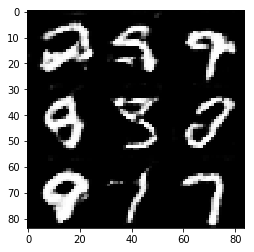

Epoch 2/2... Discriminator Loss: 1.3964... Generator Loss: 0.3784
Epoch 2/2... Discriminator Loss: 1.1205... Generator Loss: 0.5426
Epoch 2/2... Discriminator Loss: 1.8289... Generator Loss: 0.2737
Epoch 2/2... Discriminator Loss: 1.5589... Generator Loss: 0.4567
Epoch 2/2... Discriminator Loss: 1.4473... Generator Loss: 0.4259
Epoch 2/2... Discriminator Loss: 1.1068... Generator Loss: 0.5743
Epoch 2/2... Discriminator Loss: 1.2719... Generator Loss: 0.4974
Epoch 2/2... Discriminator Loss: 1.2636... Generator Loss: 0.4740
Epoch 2/2... Discriminator Loss: 1.3089... Generator Loss: 0.4521
Epoch 2/2... Discriminator Loss: 2.2494... Generator Loss: 0.1724


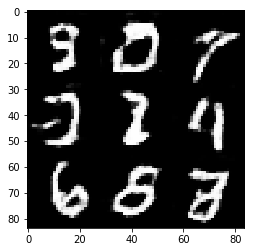

Epoch 2/2... Discriminator Loss: 1.0523... Generator Loss: 0.6458
Epoch 2/2... Discriminator Loss: 1.6798... Generator Loss: 0.2872
Epoch 2/2... Discriminator Loss: 1.9122... Generator Loss: 0.2395
Epoch 2/2... Discriminator Loss: 1.7801... Generator Loss: 0.3144
Epoch 2/2... Discriminator Loss: 1.2238... Generator Loss: 0.5293
Epoch 2/2... Discriminator Loss: 1.7910... Generator Loss: 0.2525
Epoch 2/2... Discriminator Loss: 1.0393... Generator Loss: 0.5498
Epoch 2/2... Discriminator Loss: 1.6232... Generator Loss: 0.2973
Epoch 2/2... Discriminator Loss: 1.3592... Generator Loss: 0.3706
Epoch 2/2... Discriminator Loss: 1.0972... Generator Loss: 0.4983


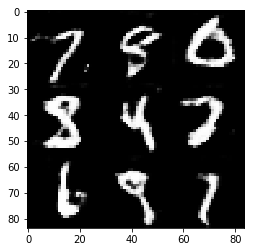

Epoch 2/2... Discriminator Loss: 1.2337... Generator Loss: 0.4843
Epoch 2/2... Discriminator Loss: 1.5297... Generator Loss: 0.3026
Epoch 2/2... Discriminator Loss: 1.3796... Generator Loss: 0.3940
Epoch 2/2... Discriminator Loss: 2.1213... Generator Loss: 0.2391
Epoch 2/2... Discriminator Loss: 1.0945... Generator Loss: 0.6437
Epoch 2/2... Discriminator Loss: 0.8421... Generator Loss: 0.9117


KeyboardInterrupt: 

In [35]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

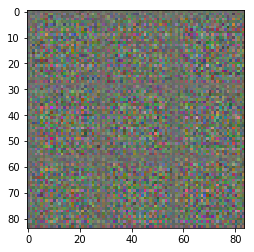

Epoch 1/1... Discriminator Loss: 3.2975... Generator Loss: 0.0449
Epoch 1/1... Discriminator Loss: 2.2462... Generator Loss: 0.1677
Epoch 1/1... Discriminator Loss: 2.3970... Generator Loss: 0.1225
Epoch 1/1... Discriminator Loss: 2.7882... Generator Loss: 0.0800
Epoch 1/1... Discriminator Loss: 1.9235... Generator Loss: 0.2615
Epoch 1/1... Discriminator Loss: 1.8012... Generator Loss: 0.2706
Epoch 1/1... Discriminator Loss: 1.8925... Generator Loss: 0.2933
Epoch 1/1... Discriminator Loss: 1.8592... Generator Loss: 0.4075
Epoch 1/1... Discriminator Loss: 1.8389... Generator Loss: 0.4033
Epoch 1/1... Discriminator Loss: 1.7580... Generator Loss: 0.3341


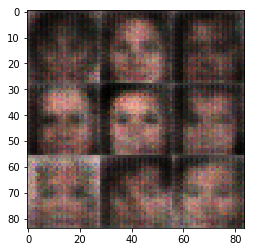

Epoch 1/1... Discriminator Loss: 1.7235... Generator Loss: 0.3506
Epoch 1/1... Discriminator Loss: 1.6647... Generator Loss: 0.3461
Epoch 1/1... Discriminator Loss: 1.9410... Generator Loss: 0.2878
Epoch 1/1... Discriminator Loss: 1.7554... Generator Loss: 0.3748
Epoch 1/1... Discriminator Loss: 1.5685... Generator Loss: 0.5152
Epoch 1/1... Discriminator Loss: 2.0716... Generator Loss: 0.2092
Epoch 1/1... Discriminator Loss: 1.9377... Generator Loss: 0.2491
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.7675... Generator Loss: 0.4193
Epoch 1/1... Discriminator Loss: 2.4797... Generator Loss: 0.1202


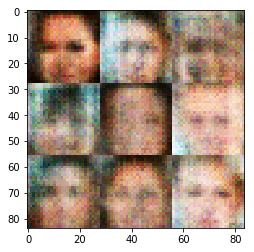

Epoch 1/1... Discriminator Loss: 1.7282... Generator Loss: 0.3442
Epoch 1/1... Discriminator Loss: 1.6071... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.9595... Generator Loss: 0.2328
Epoch 1/1... Discriminator Loss: 1.6207... Generator Loss: 0.4039
Epoch 1/1... Discriminator Loss: 1.8471... Generator Loss: 0.2649
Epoch 1/1... Discriminator Loss: 1.7072... Generator Loss: 0.3746
Epoch 1/1... Discriminator Loss: 1.9513... Generator Loss: 0.2229
Epoch 1/1... Discriminator Loss: 1.7533... Generator Loss: 0.4236
Epoch 1/1... Discriminator Loss: 1.8054... Generator Loss: 0.3634
Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.5384


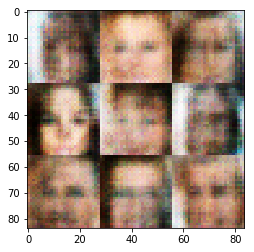

Epoch 1/1... Discriminator Loss: 1.6575... Generator Loss: 0.4068
Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 1.9735... Generator Loss: 0.2194
Epoch 1/1... Discriminator Loss: 1.6866... Generator Loss: 0.4186
Epoch 1/1... Discriminator Loss: 1.6831... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.7130... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 1.7986... Generator Loss: 0.3407
Epoch 1/1... Discriminator Loss: 1.7249... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.5856... Generator Loss: 0.4028
Epoch 1/1... Discriminator Loss: 1.6090... Generator Loss: 0.5382


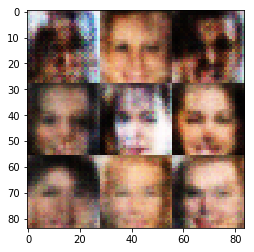

Epoch 1/1... Discriminator Loss: 1.8296... Generator Loss: 0.4044
Epoch 1/1... Discriminator Loss: 1.5923... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 1.6090... Generator Loss: 0.4684
Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.5741... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.7341... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.5733
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.6703... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 1.6501... Generator Loss: 0.5251


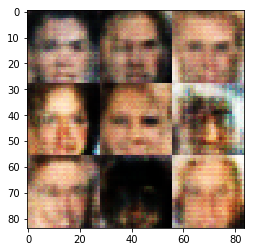

Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 1.6539... Generator Loss: 0.5228
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.5775... Generator Loss: 0.4948
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.4545
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.5858... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.5760... Generator Loss: 0.4774


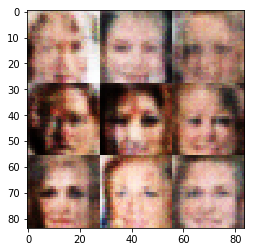

Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.5082
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.5050
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.5516
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.5212
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.6160... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.5008


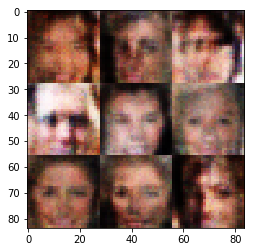

Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.5097
Epoch 1/1... Discriminator Loss: 1.5497... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.5752


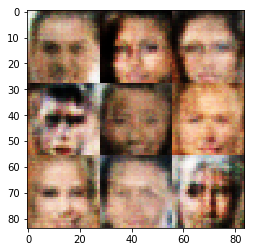

Epoch 1/1... Discriminator Loss: 1.6092... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.5705... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 1.5693... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 1.5700... Generator Loss: 0.5115
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.6157


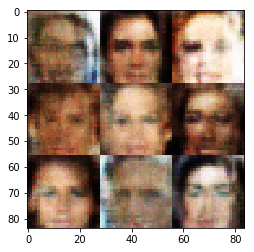

Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.4622
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.5976... Generator Loss: 0.4539


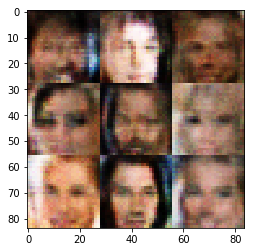

Epoch 1/1... Discriminator Loss: 1.7786... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.5405... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.5743
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.6134... Generator Loss: 0.5892


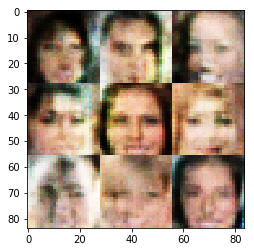

Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.5071
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.5455
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.5741
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.5541
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.6376... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.5365... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.5359
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.5499


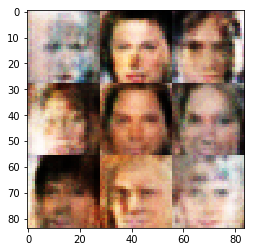

Epoch 1/1... Discriminator Loss: 1.5648... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.5376... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 1.5663... Generator Loss: 0.5197
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.5495
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.6185... Generator Loss: 0.4771
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.4979
Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.5476


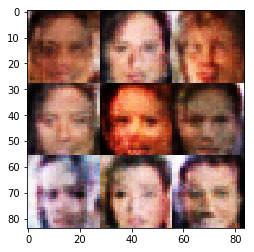

Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 1.5620... Generator Loss: 0.4954
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 1.5337... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.5525... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.5831... Generator Loss: 0.4840
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.5575


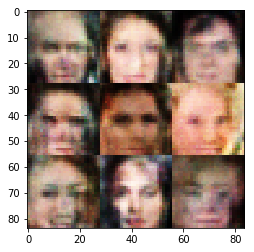

Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.5166... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 0.4069
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.5577
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.5158
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.4995
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.5706


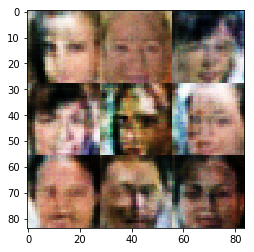

Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.5599... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.6396... Generator Loss: 0.4682
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.5464... Generator Loss: 0.4737
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.5675


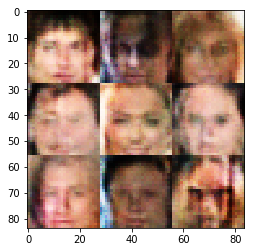

Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 0.4682
Epoch 1/1... Discriminator Loss: 1.6504... Generator Loss: 0.5049
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.6289... Generator Loss: 0.4108


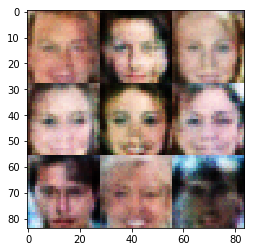

Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.5997... Generator Loss: 0.4506
Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.5280
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.4970
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.6000... Generator Loss: 0.5071
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.5310


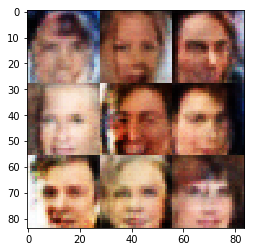

Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.5106
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.5372
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.4524
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.4934
Epoch 1/1... Discriminator Loss: 1.6019... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.5708


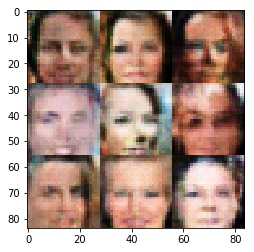

Epoch 1/1... Discriminator Loss: 1.5639... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.5687... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 1.5714... Generator Loss: 0.4847
Epoch 1/1... Discriminator Loss: 1.5347... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.5649... Generator Loss: 0.4188
Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.5502


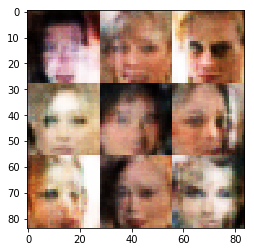

Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 1.5793... Generator Loss: 0.4931
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.5011
Epoch 1/1... Discriminator Loss: 1.5840... Generator Loss: 0.4382
Epoch 1/1... Discriminator Loss: 1.5992... Generator Loss: 0.5216
Epoch 1/1... Discriminator Loss: 1.5972... Generator Loss: 0.5063
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.4691
Epoch 1/1... Discriminator Loss: 1.5920... Generator Loss: 0.6418


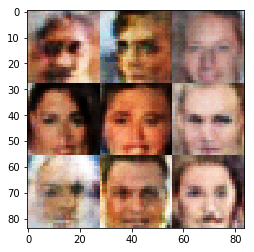

Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.5111
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.4603
Epoch 1/1... Discriminator Loss: 1.5888... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.5138
Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 0.4704


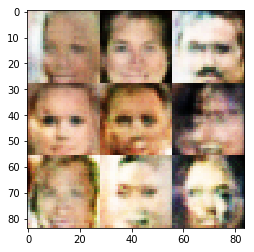

Epoch 1/1... Discriminator Loss: 1.6206... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.5734
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.5355... Generator Loss: 0.5036
Epoch 1/1... Discriminator Loss: 1.5498... Generator Loss: 0.4214
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.3802
Epoch 1/1... Discriminator Loss: 1.6456... Generator Loss: 0.5213
Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.5387


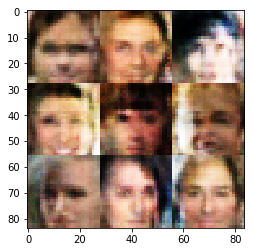

Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.5385... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.5365... Generator Loss: 0.4830
Epoch 1/1... Discriminator Loss: 1.5810... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 1.5764... Generator Loss: 0.4484
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.5741... Generator Loss: 0.4491


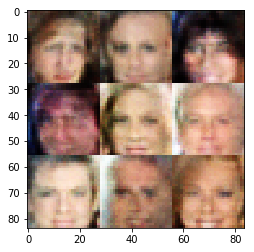

Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.6368... Generator Loss: 0.4047
Epoch 1/1... Discriminator Loss: 1.6532... Generator Loss: 0.4366


KeyboardInterrupt: 

In [36]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.